# PPO
---

### 1. Import the Necessary Packages

In [1]:
from model.ppo_3 import PPO
from env.wrappers import *
from env.ant_disturbances import *
from utils.logger import WandbSummaryWritter
import torch
from networks.mlp import MLP, DummyEncoder
from networks.LSTMAdaptiveActorCritic import LSTMAdaptiveActorCritic

### 2. Instantiate the Model

Setup the hyperparameters in the code cell below.

In [2]:
# hyperparameters = {
#     'timesteps_per_batch': 1024 ,                # Number of timesteps to run per batch
#     'max_timesteps_per_episode': 1200,           # Max number of timesteps per episode
#     'n_updates_per_iteration': 5,                # Number of times to update actor/critic per iteration
#     'lr': 2.5e-4 ,                                # Learning rate of actor optimizer
#     'gamma': 0.95,                               # Discount factor to be applied when calculating Rewards-To-Go
# }
# hyperparameters = {'gamma': 0.999, 'lr_gamma': 0.995,
#                    'max_timesteps_per_episode': 1200,'lr': 0.005 }

hyperparameters = {}

misc_hyperparameters = {
    'env': Ant,
    'activation': torch.nn.ReLU,
    'base_encoder_class': MLP,
    'adaptive_class': LSTMAdaptiveActorCritic,
    'env_args': {
        'env_class': Ant_Stiffness,
        'known_disturbances':True,
        'min_stiff':0,
        'max_stiff':10,
    }
}

Initialise wandb session in the code cell below.

In [3]:
LOG = False
if LOG:
    logger = WandbSummaryWritter(project='ant', config =misc_hyperparameters['env']().load_hyperparameters())
else:
    logger=None

Initialise the model fo the desired timestamps. Alternatively can specify a checkpoint to continue training.

In [4]:
checkpoint = 'ppo_checkpoints/ant-45'
# checkpoint = 'ppo_checkpoints/ant-1'
LOAD_MODEL = True

ppo = PPO(logger, **hyperparameters, **misc_hyperparameters)

if LOAD_MODEL:
    ppo.policy.load_state_dict(torch.load(checkpoint + "/ppo_policy_500.pth"))
    # ppo.adpt_module.load_state_dict(torch.load(checkpoint + "/adp_model.pth"))
    # ppo.adapt_policy.set_policy(ppo.policy)

/tmp/ipykernel_182016/2149242748.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ppo.policy.load_state_dict(torch.load(checkpoint + "/ppo_policy_500.pth"))


### 3. Train the Model

Train model for specified amount of timestamps.

In [5]:
ppo.train()
# ppo.train_adaptive_module()


-------------------- Iteration1/200 --------------------
Average adp Loss: 1.40335
Iteration took: 5.23 secs, of which rollout took 0 secs and gradient updates took 0.0 secs
Current adp learning rate: 0.002
------------------------------------------------------


-------------------- Iteration2/200 --------------------
Average adp Loss: 1.12074
Iteration took: 5.11 secs, of which rollout took 0 secs and gradient updates took 0.0 secs
Current adp learning rate: 0.002
------------------------------------------------------


-------------------- Iteration3/200 --------------------
Average adp Loss: 0.89524
Iteration took: 5.01 secs, of which rollout took 0 secs and gradient updates took 0.0 secs
Current adp learning rate: 0.002
------------------------------------------------------


-------------------- Iteration4/200 --------------------
Average adp Loss: 0.77591
Iteration took: 4.94 secs, of which rollout took 0 secs and gradient updates took 0.0 secs
Current adp learning rate: 0.002


### 4. Evaluate the Model

Run multiple episodes from pretrained model.

In [6]:
import os
i = 1
path = f"./trained_models/"
os.makedirs(path, exist_ok=True)
torch.save(ppo.policy.state_dict(), path + "base.pth")
torch.save(ppo.adpt_module.state_dict(), path + "adpt.pth")
# ppo.test(False)

In [7]:

import numpy as np
MAX_IT = 100
val_t = np.zeros(MAX_IT)
val_rew = np.zeros(MAX_IT)
ppo.policy.cpu()
env = ppo.env_class(num_envs=1, **ppo.env_args)
for i in  range(0, MAX_IT):
        obs, done = env.reset()
        model = env.envs[0].model
        t = 1
        reward = 0
        while not done[0] and t < 1000:
            action = ppo.policy.sample_action(torch.Tensor(obs))
            obs, rew, done = env.step(action.numpy())
            t+=1
            reward+=rew
        val_t[i] = t
        val_rew[i] =reward
print(np.mean(val_t), np.mean(val_rew))
#752.86 1538.6648483656134

/tmp/ipykernel_182016/460438398.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_rew[i] =reward


986.21 784.0005480206084


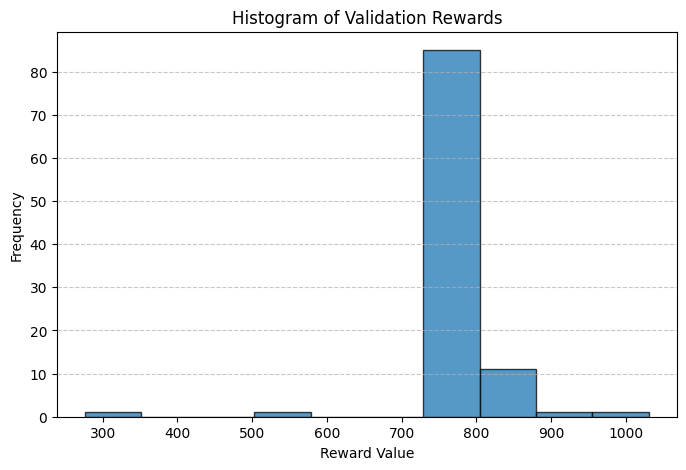

{'Mean': 784.0005480206084, 'Median': 784.231285284731, 'Max': 1030.8720234429, 'Standard Deviation': 66.24805125618275, '25th Percentile': 776.7771134919083, '75th Percentile': 791.7301356618495}


In [8]:
import matplotlib.pyplot as plt

# Replace this with your actual 100 validation reward values
validation_rewards = val_rew

# Create histogram
plt.figure(figsize=(8, 5))
plt.hist(validation_rewards, bins=10, edgecolor='black', alpha=0.75)

# Labels and title
plt.xlabel('Reward Value')
plt.ylabel('Frequency')
plt.title('Histogram of Validation Rewards')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

stats = {
    "Mean": np.mean(validation_rewards),
    "Median": np.median(validation_rewards),
    "Max": np.max(validation_rewards),
    "Standard Deviation": np.std(validation_rewards),
    "25th Percentile": np.percentile(validation_rewards, 25),
    "75th Percentile": np.percentile(validation_rewards, 75)
}

print(stats)


In [9]:
# import os
# os.environ["MUJOCO_GL"] = "wgl"
# env.close()
# ppo.policy.cpu()
# env = ppo.env_class(num_envs=1, **ppo.env_args)
# while True:
#     obs, done = env.reset()
#     model = env.envs[0].model
#     t = 1
#     while not done[0] and t < 1_000:
#         action = ppo.policy.sample_action(torch.Tensor(obs))
#         obs, _, done = env.step(action.numpy())
#         t+=1

In [10]:
ppo.adapt_policy.clear_history()

wind_vals = []
base_z = []
adpt_z = []
ppo.policy.to(ppo.device)
env = ppo.env_class(num_envs=1, **ppo.env_args)
obs, done = env.reset()

reward = 0
t = 0
while not done[0] and t < 1_000:
    wind_vals.append(obs[0, -1])

    obs_tensor = torch.tensor(obs, dtype=torch.float32).to(ppo.device)
    action,_ = ppo.adapt_policy.sample_action(obs_tensor)

    base_output = ppo.policy.encoder(obs_tensor).detach().cpu().numpy().flatten()[0]
    adpt_output = ppo.adapt_policy.encode(obs_tensor).detach().cpu().numpy().squeeze()[-1]
    base_z.append(base_output)
    adpt_z.append(adpt_output)
    obs, rew, done = env.step(action.cpu().numpy())
    reward += rew
    t+=1
    if t % 1000 == 0:
        print(t, reward)
print(t, reward)
print(wind_vals[0], base_z[0])

RuntimeError: Expected hidden[0] size (1, 1, 256), got [1, 50, 256]

In [ ]:
from scipy.spatial.distance import euclidean, cityblock, cosine

ppo.adapt_policy.clear_history()

wind_vals = []
base_z = []
adpt_z = []
ppo.policy.to(ppo.device)
env = ppo.env_class(num_envs=1, **ppo.env_args)
obs, done = env.reset()

reward = 0
t = 0
while not done[0] and t < 5000:
    wind_vals.append(obs[0, -1])

    obs_tensor = torch.tensor(obs, dtype=torch.float32).to(ppo.device)
    action,_ = ppo.adapt_policy.sample_action(obs_tensor)

    base_output = ppo.policy.encoder(obs_tensor).detach().cpu().numpy().squeeze().flatten()[0]
    adpt_output = ppo.adapt_policy.encode(obs_tensor).detach().cpu().numpy().squeeze()[-1]
    base_z.append(base_output)
    adpt_z.append(adpt_output)

    # print(base_output - adpt_output)

    obs, rew, done = env.step(action.cpu().numpy())
    reward += rew
    t+=1
    if t % 1000 == 0:
        print(t, reward)
print(t, reward)
# print(wind_vals[0], base_z[0])
print(base_z)
print(adpt_z)

1000 [778.23830935]
1000 [778.23830935]
[0.8238176, 10.99562, 1.6752288, -1.0334408, 0.877373, 0.16883987, 0.016570479, -0.20047544, 0.31511858, 0.43525282, 0.4493697, 0.709002, 0.68997395, 0.69922566, 0.6480733, 1.1916914, 0.53972375, 0.42073837, 0.08847958, 0.8090172, 0.23092219, 0.2004309, 0.34430107, 1.0502859, 1.2999443, 0.68928516, -0.10331538, 0.2664057, 0.5680413, 0.9914912, 0.3257294, 0.8292309, 0.81727064, 0.57663035, 0.6800959, 0.3596092, -0.10331538, -0.10331538, -0.17631745, 0.34709516, 0.5748304, 1.3229539, 0.9696386, 0.7500576, 0.17948994, -0.10331538, -0.10331538, -0.10331538, 0.20260522, 0.5287974, 0.9041467, 0.995893, 1.6929233, 1.2595475, 0.4620864, 0.01602684, -1.6656148, 1.7536017, 1.0423362, 0.2839873, 0.434011, 0.6878061, 0.8848821, 0.863431, 0.27702114, 1.08853, 0.84116054, 0.68268657, 0.6566899, 0.6120976, 0.2905758, 1.0289375, 0.6708851, 0.8748833, 0.91443515, 0.6874211, 1.3184882, 0.4535431, 0.8218342, 0.9494952, 0.8385428, 0.91634846, 0.8815342, 0.8634205, 0

[5.642906665802002, 9.268989562988281, 0.8150999546051025, 2.173069477081299, 0.06605923175811768, 0.6961782574653625, 0.8361108303070068, 1.1455901861190796, 0.6272631883621216, 0.2633638083934784, 0.031291067600250244, 0.2325529158115387, 0.264485239982605, 0.18453115224838257, 0.04400455951690674, 0.8161988258361816, 0.18212759494781494, 0.05425956845283508, 0.28783565759658813, 0.2965537905693054, 0.6173230409622192, 0.42704638838768005, 0.39598917961120605, 1.2194910049438477, 1.3382185697555542, 0.6092503070831299, 0.6495605707168579, 0.8431310653686523, 0.43081697821617126, 0.9423816204071045, 0.10940080881118774, 0.4954671561717987, 0.022295236587524414, 0.35290446877479553, 0.6466195583343506, 0.21270611882209778, 0.37714311480522156, 0.26411569118499756, 0.5366388559341431, 0.5086832046508789, 0.35097837448120117, 1.0105048418045044, 0.7924787998199463, 0.5270028114318848, 0.5017256140708923, 0.4315028488636017, 0.4821934700012207, 0.4593826234340668, 0.4289759695529938, 0.27

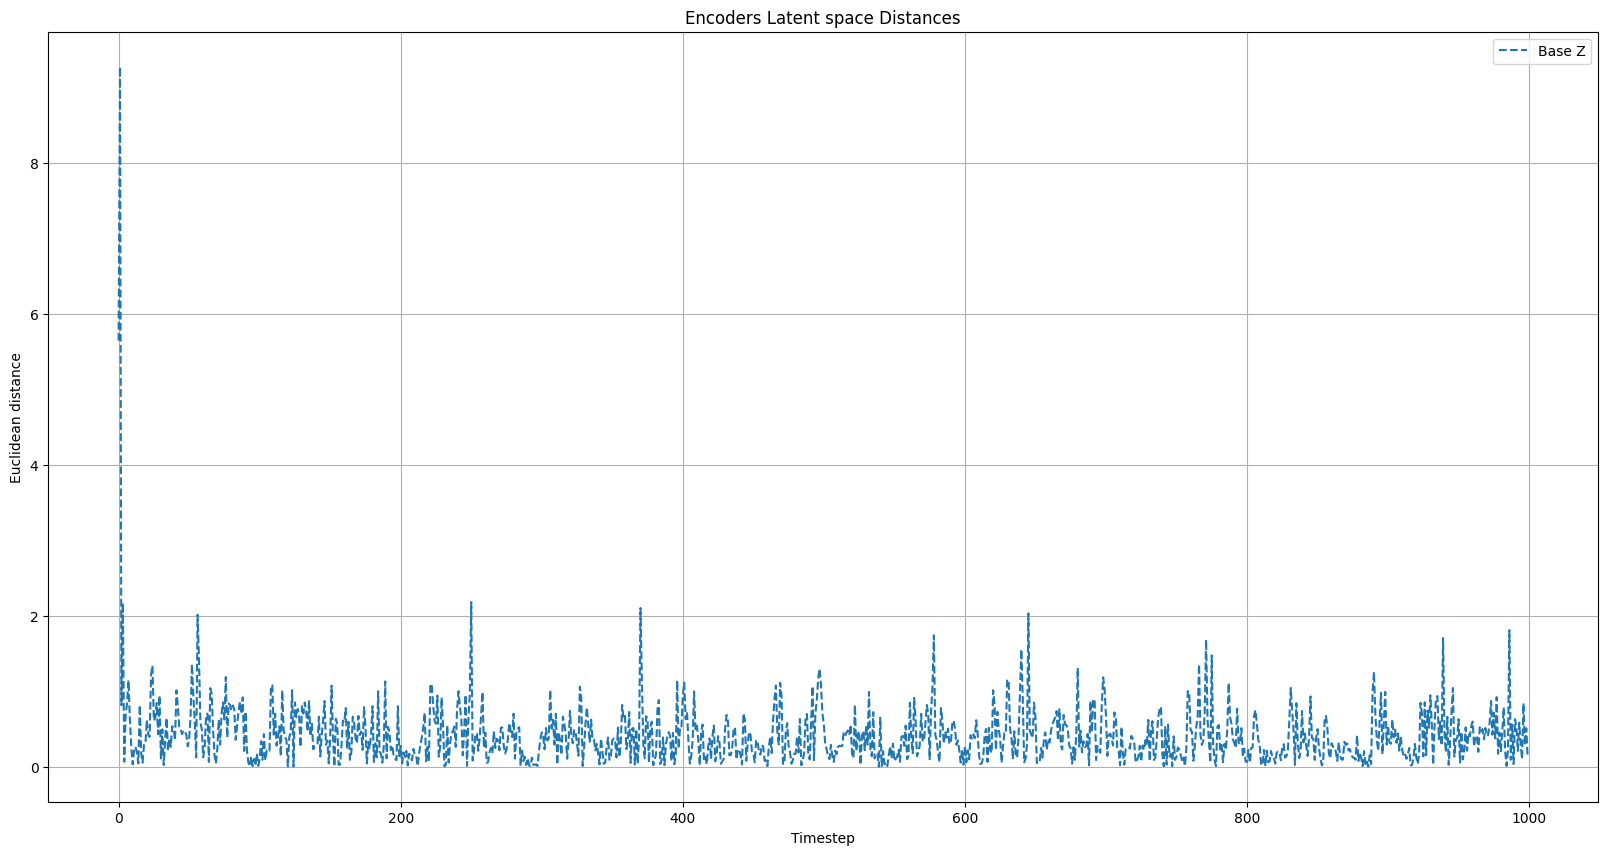

In [ ]:
import matplotlib.pyplot as plt

distances = []

for i in range(len(base_z)):
    distances.append(euclidean([base_z[i]], [adpt_z[i]]))

print(distances)
indices = range(len(distances))

plt.figure(figsize=(20, 10))
plt.plot(indices, distances, label="Base Z", linestyle='--')

plt.xlabel("Timestep")
plt.ylabel("Euclidean distance")
plt.title(f"Encoders Latent space Distances")
plt.legend()
plt.grid(True)

plt.show()

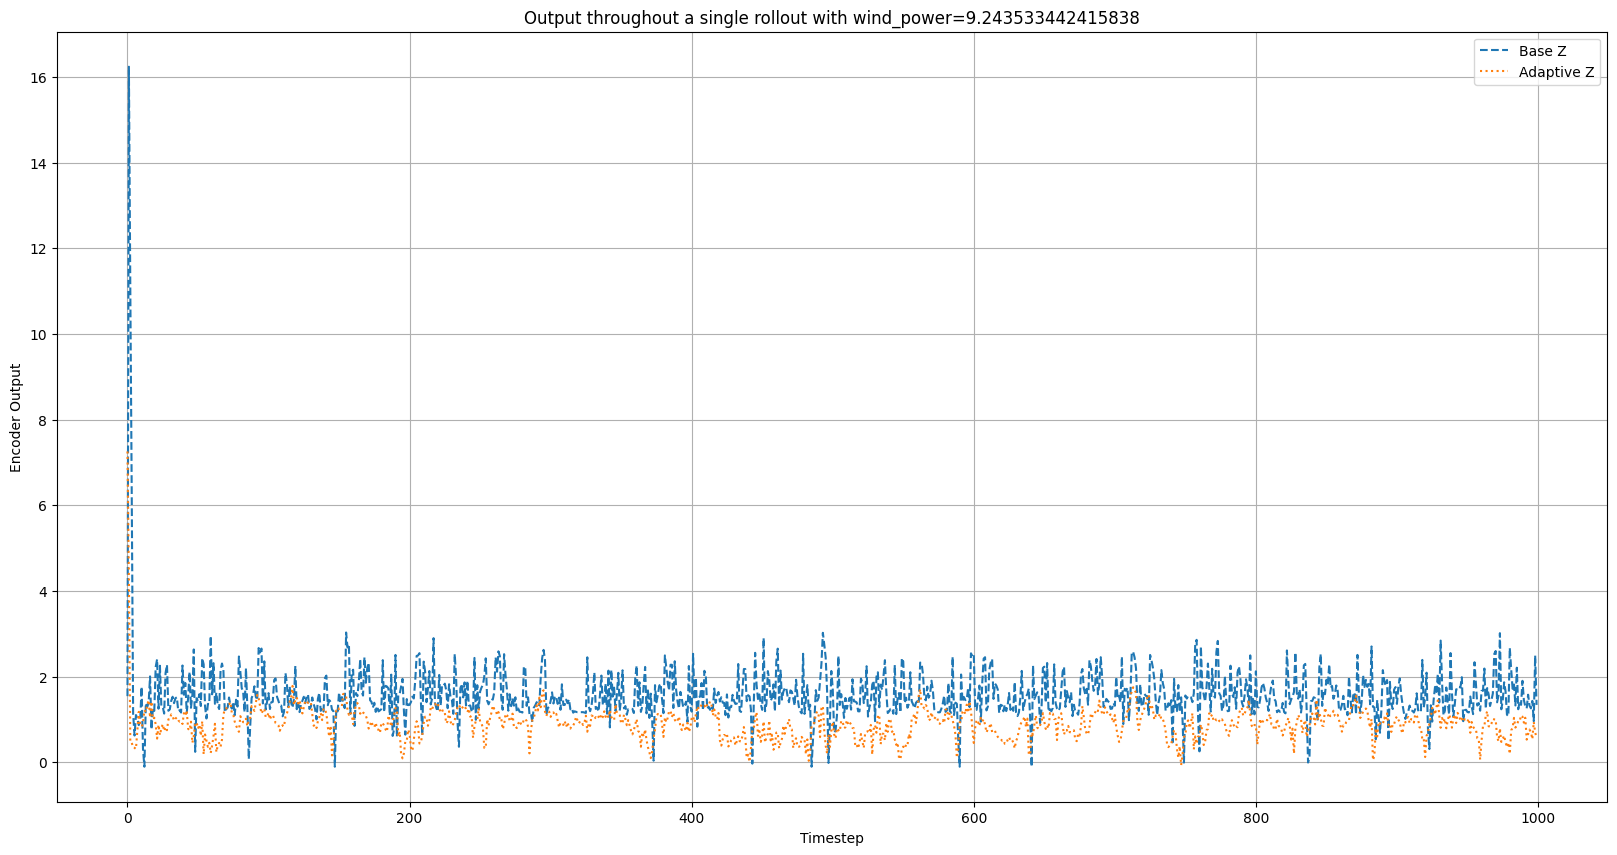

In [ ]:
import matplotlib.pyplot as plt

# wind_vals, base_z, adpt_z = ppo.validate_encoders_single_rollout()
indices = range(len(wind_vals))

plt.figure(figsize=(20, 10))
plt.plot(indices, base_z, label="Base Z", linestyle='--')
plt.plot(indices, adpt_z, label="Adaptive Z", linestyle=':')

plt.xlabel("Timestep")
plt.ylabel("Encoder Output")
plt.title(f"Output throughout a single rollout with wind_power={wind_vals[0]}")
plt.legend()
plt.grid(True)

plt.show()

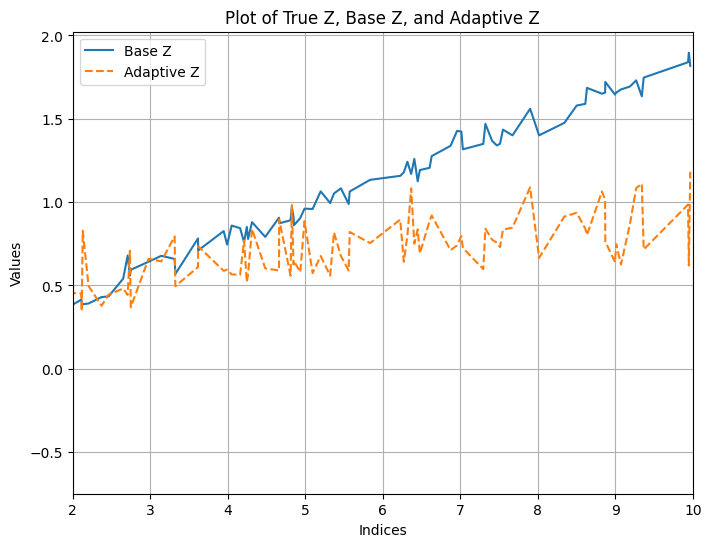

In [ ]:
import numpy as np
t_winds, b_z, a_z = ppo.validate_encoders(100, 150)
sorted_indices = np.argsort(t_winds)
plt.figure(figsize=(8, 6))
plt.plot(t_winds[sorted_indices], b_z[sorted_indices], label="Base Z")
plt.plot(t_winds[sorted_indices], a_z.cpu().numpy()[sorted_indices], label="Adaptive Z", linestyle='--')

plt.xlabel("Indices")
plt.xlim(2, 10)
plt.ylabel("Values")
plt.title("Plot of True Z, Base Z, and Adaptive Z")
plt.legend()
plt.grid(True)

plt.show()